In [ ]:
!git clone https://github.com/Alireza-Akhavan/object-detection-notebooks.git

This notebook is part of "Object detection course":
    https://github.com/Alireza-Akhavan/object-detection-notebooks

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices()

2.2.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [3]:
BASE_PATH = "dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

In [4]:
rows = open(ANNOTS_PATH).read().strip().split("\n")

In [5]:
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

In [6]:
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    (filename, startX, startY, endX, endY) = row.split(",")

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [7]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [9]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [11]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [12]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add( Dense(128, activation="relu"))
model.add( Dense(64, activation="relu"))
model.add( Dense(32, activation="relu"))
model.add( Dense(4, activation="sigmoid"))

In [13]:
vgg.trainable = False

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 17,936,548
Trainable params: 3,221,860
Non-trainable params: 14,714,688
____________________________________

In [15]:
opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)

In [16]:
H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=32,
epochs=25,
verbose=1)

Epoch 1/25
23/23 [==============================] - 24s 1s/step - loss: 0.0205 - val_loss: 0.0051
Epoch 2/25
23/23 [==============================] - 21s 931ms/step - loss: 0.0023 - val_loss: 8.6541e-04
Epoch 3/25
23/23 [==============================] - 21s 905ms/step - loss: 0.0011 - val_loss: 6.2884e-04
Epoch 4/25
23/23 [==============================] - 21s 928ms/step - loss: 9.4032e-04 - val_loss: 5.8869e-04
Epoch 5/25
23/23 [==============================] - 22s 941ms/step - loss: 7.9146e-04 - val_loss: 5.5063e-04
Epoch 6/25
23/23 [==============================] - 22s 941ms/step - loss: 6.9295e-04 - val_loss: 5.3969e-04
Epoch 7/25
23/23 [==============================] - 22s 949ms/step - loss: 5.9885e-04 - val_loss: 5.6391e-04
Epoch 8/25
23/23 [==============================] - 22s 957ms/step - loss: 5.1892e-04 - val_loss: 5.2229e-04
Epoch 9/25
23/23 [==============================] - 22s 957ms/step - loss: 4.5543e-04 - val_loss: 5.2050e-04
Epoch 10/25
23/23 [===================

In [17]:
model.save("localization.h5", save_format="h5")

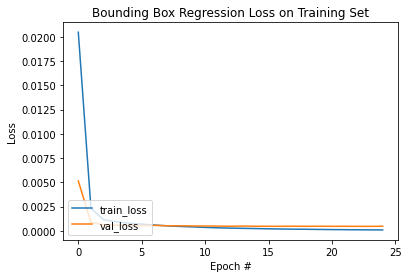

In [18]:
N = H.params['epochs']
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

Source:

https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/